# Bayes Opt on 2D Regular Graph

In [268]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [269]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [270]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [271]:
def gp_inference(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None)
    model.likelihood.variance.prior = tfp.distributions.LogNormal(loc=np.log(0.07), scale=0.5)
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

In [272]:
def plot_2d(Z, mesh_size, ax, points=None, highlight=None, title='', cmap='viridis'):
    Z2D = Z.reshape(mesh_size, mesh_size)
    x = np.arange(mesh_size)
    y = np.arange(mesh_size)
    Xg, Yg = np.meshgrid(x, y)
    cs = ax.contourf(Xg, Yg, Z2D, levels=25, cmap=cmap)
    if points is not None:
        px, py = points % mesh_size, points // mesh_size
        ax.scatter(px, py, marker='x', c='white', s=50)
    if highlight is not None:
        hx, hy = highlight % mesh_size, highlight // mesh_size
        ax.scatter(hx, hy, marker='*', c='red', s=80)
    ax.set_title(title)
    return cs

In [273]:
# Parameters
mesh_size = 15
num_nodes = mesh_size**2
graph_type = '2D_mesh' # 'line', 'random', '2D_mesh'

In [274]:
if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix
elif graph_type == '2D_mesh':
    adjacency_matrix = nx.adjacency_matrix(nx.grid_2d_graph(mesh_size, mesh_size)).todense()

In [275]:
beta_sample = 10
noise_std = 0.1
kernel_std = 10

In [276]:
K_true = kernel_std * diffusion_kernel(adjacency_matrix, beta_sample)
Y = generate_noisy_samples(K_true, noise_std=0, seed=0)
X = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))  # Input features (nodes)

In [277]:
def plot_covariance(node_idx):
    # Extract the covariance row for the chosen node and reshape it
    cov_row = np.array(K_true[node_idx]).flatten()
    cov_grid = cov_row.reshape(mesh_size, mesh_size)
    
    plt.figure(figsize=(6, 5))
    im = plt.imshow(cov_grid, cmap='viridis')
    plt.colorbar(im)
    
    # Determine the 2D position for the node in the grid
    row_idx = node_idx // mesh_size
    col_idx = node_idx % mesh_size
    # Highlight the chosen node with a circle
    plt.scatter(col_idx, row_idx, s=150, facecolors='none', edgecolors='red', linewidths=2)
    plt.title(f"Covariance from Node {node_idx}")
    plt.show()

widgets.interact(plot_covariance, node_idx=widgets.IntSlider(min=0, max=num_nodes-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='node_idx', max=224), Output()), _dom_classes=('widget-in…

<function __main__.plot_covariance(node_idx)>

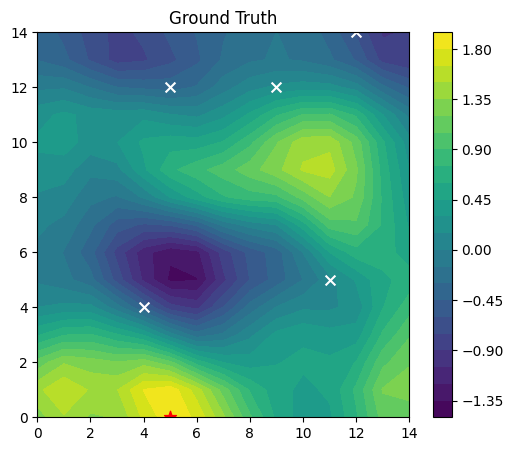

In [278]:
# Ground truth best
gt_best_point = np.argmax(Y)
gt_best_value = Y[gt_best_point]

# Initial subsampling
subsample_factor = 20
sub_idx = np.random.choice(num_nodes, min(num_nodes // subsample_factor, 5), replace=False)
X_sub = X.numpy()[sub_idx]
Y_sub = Y[sub_idx]

# Visualization the Ground Truth surface, overlayed with the initial subsampling, with colour bar
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_2d(Y, mesh_size, ax, points=sub_idx, highlight=gt_best_point, title='Ground Truth')
plt.colorbar(plot_2d(Y, mesh_size, ax, points=sub_idx, highlight=gt_best_point, title='Ground Truth'))
plt.show()

In [279]:
kernel = GraphDiffusionKernel(adjacency_matrix=adjacency_matrix)
model, mean, stddev = gp_inference(X_sub, Y_sub, X, kernel)

results = {
    'iteration': [],
    'subsample_idx': [],
    'sample_idx': [],
    'sample_value': [],
    'best_value': [],
    'best_point': [],
    'mean': [],
    'stddev': [],
    'thompson_samples': [],
    'beta': [],
    'sigma_f': [],
    'noise_var': []
}

best_val = -np.inf
best_pt = None
num_iter = 30

for i in tqdm(range(num_iter)):
    thompson = model.predict_f_samples(X, 1).numpy().ravel()
    next_idx = np.argmax(thompson)
    next_val = Y[next_idx] + np.random.normal(0, noise_std) # add noise
    if next_val > best_val:
        best_val = next_val
        best_pt = next_idx

    sub_idx = np.append(sub_idx, next_idx)
    X_sub = X.numpy()[sub_idx]
    Y_sub = Y[sub_idx]

    model, mean, stddev = gp_inference(X_sub, Y_sub, X, kernel)

    results['iteration'].append(i+1)
    results['subsample_idx'].append(sub_idx.copy())
    results['sample_idx'].append(next_idx)
    results['sample_value'].append(next_val)
    results['best_value'].append(best_val)
    results['best_point'].append(best_pt)
    results['mean'].append(mean.numpy().copy())
    results['stddev'].append(stddev.numpy().copy())
    results['thompson_samples'].append(thompson.copy())
    results['beta'].append(float(model.kernel.beta.numpy()))
    results['sigma_f'].append(float(model.kernel.sigma_f.numpy()))
    results['noise_var'].append(float(model.likelihood.variance.numpy()))

results_df = pd.DataFrame(results)

print(f"Ground truth best: value={gt_best_value[0]:.3f}, idx={gt_best_point}")
print(f"Best by BO: value={best_val[0]:.3f}, idx={best_pt}")

100%|██████████| 30/30 [00:22<00:00,  1.30it/s]

Ground truth best: value=1.904, idx=5
Best by BO: value=1.755, idx=16


In [280]:
results_df.head()

,iteration,subsample_idx,sample_idx,sample_value,best_value,best_point,mean,stddev,thompson_samples,beta,sigma_f,noise_var
0,1,"[86, 189, 185, 222, 64, 126]",126,[0.45272497303157416],[0.45272497303157416],126,"[[-8.12000987235532e-05], [-0.0002665183367712...","[[0.37819691016405116], [0.39511538024675247],...","[0.5116652176845171, 0.6880751586886388, 0.422...",3.172014,0.950345,0.054269
1,2,"[86, 189, 185, 222, 64, 126, 202]",202,[-0.25778500028878387],[0.45272497303157416],126,"[[-0.00031707927438178797], [-0.00085915391111...","[[0.3625288393950929], [0.38408579709155316], ...","[0.06212203642777319, 0.3482368760687913, 0.37...",3.965707,1.015431,0.054013
2,3,"[86, 189, 185, 222, 64, 126, 202, 15]",15,[1.496817473711596],[1.496817473711596],15,"[[1.1461653995660783], [1.1811256144845312], [...","[[0.25020064444194395], [0.35585008434979454],...","[0.80556754789089, 0.6851729298822531, 0.36904...",7.528306,2.356897,0.052737
3,4,"[86, 189, 185, 222, 64, 126, 202, 15, 1]",1,[1.5463590184077678],[1.5463590184077678],1,"[[1.2663339863321081], [1.4084528585389886], [...","[[0.1521460217060186], [0.18017162545405507], ...","[1.3089967122590749, 1.5804419985125346, 1.282...",9.907162,2.791780,0.048436
4,5,"[86, 189, 185, 222, 64, 126, 202, 15, 1, 165]",165,[0.2418966904119099],[1.5463590184077678],1,"[[1.2630116047787328], [1.4008643403494225], [...","[[0.15201921440803648], [0.17901909591516596],...","[1.0533553358828949, 1.1934140222890335, 1.014...",9.424896,2.576897,0.048136


In [281]:
def interactive_bayesopt_plot(results_df, Y, mesh_size, gt_best_value, gt_best_point):
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(results_df) - 1,
        step=1,
        description='Iteration'
    )

    def plot_iteration(iter_idx):
        row = results_df.iloc[iter_idx]
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        cs1 = plot_2d(row['mean'], mesh_size, axs[0, 0],
                      points=row['subsample_idx'], highlight=row['sample_idx'],
                      title=f"Predicted Mean (Iter {row['iteration']})")
        fig.colorbar(cs1, ax=axs[0, 0])

        cs2 = plot_2d(row['stddev'], mesh_size, axs[0, 1],
                      points=row['subsample_idx'], highlight=row['sample_idx'],
                      title="Predicted Std Dev")
        fig.colorbar(cs2, ax=axs[0, 1])

        cs3 = plot_2d(row['thompson_samples'], mesh_size, axs[1, 0],
                      points=row['subsample_idx'], highlight=row['sample_idx'],
                      title="Thompson Sample")
        fig.colorbar(cs3, ax=axs[1, 0])

        cs4 = plot_2d(Y, mesh_size, axs[1, 1],
                      points=row['subsample_idx'], highlight=row['sample_idx'],
                      title="Ground Truth")
        fig.colorbar(cs4, ax=axs[1, 1])

        title_str = (
            f"Model Parameters: beta = {row['beta']:.4f}, sigma_f = {row['sigma_f']:.4f}, noise_var = {row['noise_var']:.4f}\n"
            f"Bayes Opt: Best so far = {row['best_value'][0]:.3f} (idx = {row['best_point']})\n"
            f"Ground Truth: Best value = {gt_best_value[0]:.3f} (idx = {gt_best_point})"
        )
        fig.suptitle(title_str, fontsize=10, y=1.02)
        plt.tight_layout()
        plt.show()

    widgets.interact(plot_iteration, iter_idx=slider)

# Usage:
interactive_bayesopt_plot(results_df, Y, mesh_size, gt_best_value, gt_best_point)


interactive(children=(IntSlider(value=0, description='Iteration', max=29), Output()), _dom_classes=('widget-in…

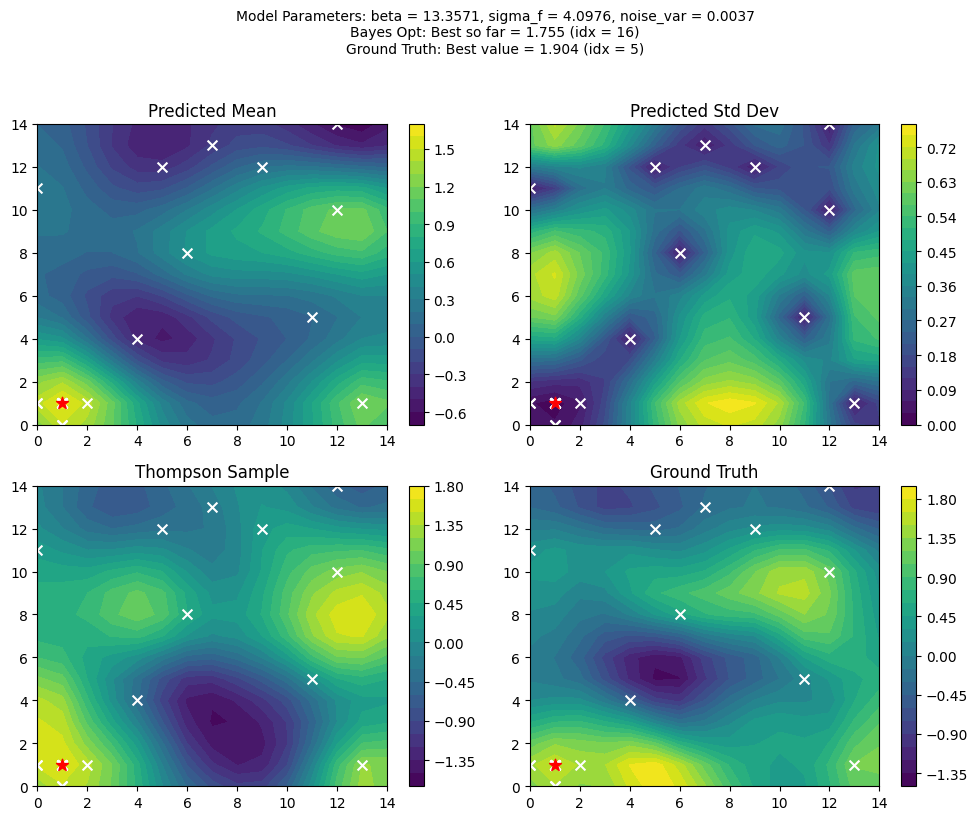

In [282]:
row = results_df.iloc[-1]
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

cs1 = plot_2d(row['mean'], mesh_size, axs[0, 0],
              points=row['subsample_idx'], highlight=row['sample_idx'],
              title="Predicted Mean")
fig.colorbar(cs1, ax=axs[0, 0])

cs2 = plot_2d(row['stddev'], mesh_size, axs[0, 1],
              points=row['subsample_idx'], highlight=row['sample_idx'],
              title="Predicted Std Dev")
fig.colorbar(cs2, ax=axs[0, 1])

cs3 = plot_2d(row['thompson_samples'], mesh_size, axs[1, 0],
              points=row['subsample_idx'], highlight=row['sample_idx'],
              title="Thompson Sample")
fig.colorbar(cs3, ax=axs[1, 0])

cs4 = plot_2d(Y, mesh_size, axs[1, 1],
              points=row['subsample_idx'], highlight=row['sample_idx'],
              title="Ground Truth")
fig.colorbar(cs4, ax=axs[1, 1])

title_str = (
    f"Model Parameters: beta = {row['beta']:.4f}, sigma_f = {row['sigma_f']:.4f}, noise_var = {row['noise_var']:.4f}\n"
    f"Bayes Opt: Best so far = {row['best_value'][0]:.3f} (idx = {row['best_point']})\n"
    f"Ground Truth: Best value = {gt_best_value[0]:.3f} (idx = {gt_best_point})"
)
fig.suptitle(title_str, fontsize=10, y=1.02)
plt.tight_layout()
plt.show()


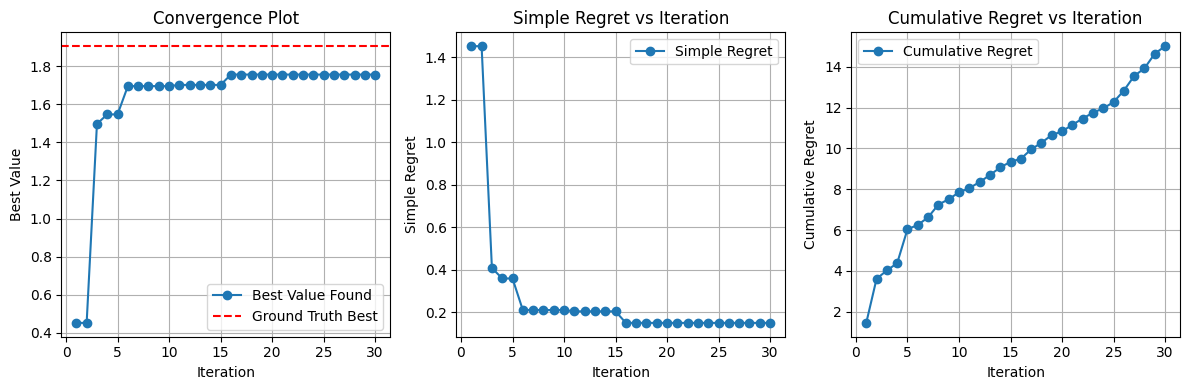

In [283]:
# Extract data from results_df (assumed to be defined)
iterations = results_df['iteration'].to_numpy()
best_values = results_df['best_value'].to_numpy()  # best observed value so far
sample_values = results_df['sample_value'].to_numpy()  # value of each chosen sample

# Calculate regrets:
simple_regret = gt_best_value - best_values
cumulative_regret = np.cumsum(gt_best_value - sample_values)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Convergence plot: best value vs iteration
axs[0].plot(iterations, best_values, marker='o', label='Best Value Found')
axs[0].axhline(y=gt_best_value, color='r', linestyle='--', label='Ground Truth Best')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Best Value')
axs[0].set_title('Convergence Plot')
axs[0].legend()
axs[0].grid(True)

# Simple Regret plot
axs[1].plot(iterations, simple_regret, marker='o', label='Simple Regret')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Simple Regret')
axs[1].set_title('Simple Regret vs Iteration')
axs[1].legend()
axs[1].grid(True)

# Cumulative Regret plot
axs[2].plot(iterations, cumulative_regret, marker='o', label='Cumulative Regret')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Cumulative Regret')
axs[2].set_title('Cumulative Regret vs Iteration')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()